In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving dataset.zip to dataset.zip
User uploaded file "dataset.zip" with length 570692946 bytes


In [0]:
import zipfile
zip_ref = zipfile.ZipFile('dataset.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [1]:
import os
os.environ['QT_QPA_PLATFORM']='offscreen'

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import pickle

from keras import backend as K
from keras import applications
K.set_image_dim_ordering('th')

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.activations import relu, sigmoid
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
training_data_folder = 'dataset/training'
validation_data_folder = 'dataset/validation'
img_width = 80
img_height = 80
channels = 3
batch_size = 64

In [3]:
from keras.models import Model
base_model = applications.VGG16(include_top=False, input_shape=(3, img_width, img_height), weights='imagenet')
fine_tuning_model = Sequential()
fine_tuning_model.add(Flatten(input_shape=base_model.output_shape[1:]))
fine_tuning_model.add(Dense(128, activation='relu'))
fine_tuning_model.add(BatchNormalization(momentum=0.3))
fine_tuning_model.add(Dropout(0.5))
fine_tuning_model.add(Dense(1, activation='sigmoid'))
model = Model(inputs= base_model.input, outputs= fine_tuning_model(base_model.output))

model.summary()

/home/francisgbuendia97/anaconda3/lib/python3.5/site-packages/keras/applications/vgg16.py:188: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 80, 80)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 80, 80)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 80, 80)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 40, 40)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 40, 40)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 40, 40)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 20, 20)       0         
__________

In [4]:
from keras.callbacks import ModelCheckpoint
adam = keras.optimizers.Adam(lr=.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

#training data
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.2,horizontal_flip=True, height_shift_range=0.2,
                                   rotation_range=40, shear_range=0.4, zoom_range=0.2, fill_mode='nearest')

#validation data
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    training_data_folder,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    validation_data_folder,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

# save weights
filepath="vgg_finetune_best_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# fine-tune the model
vgg_transfer_pt_model = model.fit_generator(
    train_generator,
    steps_per_epoch=20000//128,
    epochs=75,
    validation_data=validation_generator,
    validation_steps=5000//128,
    callbacks=callbacks_list)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/40
156/156 [==============================] - 235s 2s/step - loss: 0.5699 - acc: 0.7141 - val_loss: 0.8397 - val_acc: 0.6675

Epoch 00001: val_loss improved from inf to 0.83970, saving model to vgg_finetune_best_weights.hdf5
Epoch 2/40
156/156 [==============================] - 204s 1s/step - loss: 0.3673 - acc: 0.8393 - val_loss: 0.2291 - val_acc: 0.9083

Epoch 00002: val_loss improved from 0.83970 to 0.22910, saving model to vgg_finetune_best_weights.hdf5
Epoch 3/40
156/156 [==============================] - 56s 359ms/step - loss: 0.3058 - acc: 0.8698 - val_loss: 0.2140 - val_acc: 0.9127

Epoch 00003: val_loss improved from 0.22910 to 0.21403, saving model to vgg_finetune_best_weights.hdf5
Epoch 4/40
156/156 [==============================] - 55s 354ms/step - loss: 0.2791 - acc: 0.8833 - val_loss: 0.2124 - val_acc: 0.9195

Epoch 00004: val_loss improved from 0.21403 to 0.21239, saving model t

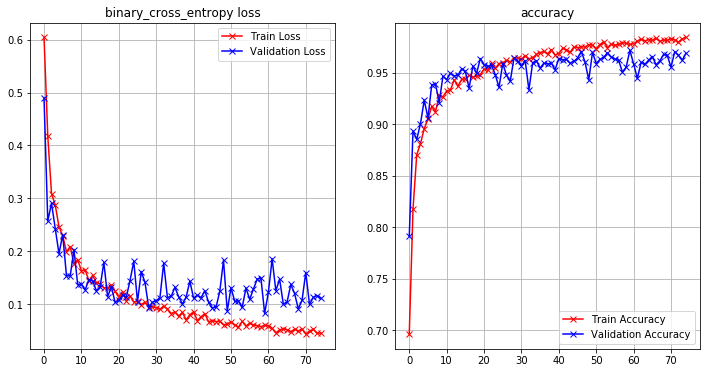

In [18]:
def plot_loss_accuracy(vgg_transfer_pt_model):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(vgg_transfer_pt_model.history["loss"],'r-x', label="Train Loss")
    ax.plot(vgg_transfer_pt_model.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('binary_cross_entropy loss')
    ax.grid(True)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(vgg_transfer_pt_model.history["acc"],'r-x', label="Train Accuracy")
    ax.plot(vgg_transfer_pt_model.history["val_acc"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)
plot_loss_accuracy(vgg_transfer_pt_model)

In [0]:
#Upload test set (files are from google drive)
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

In [0]:
import zipfile
zip_ref = zipfile.ZipFile('test1.zip', 'r')
zip_ref.extractall()
zip_ref.close()

4.89418e-06
cat


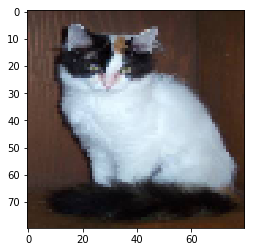

0.396673
cat


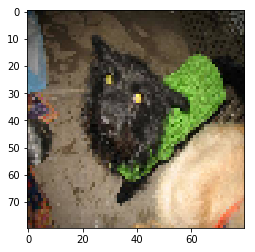

7.86991e-05
cat


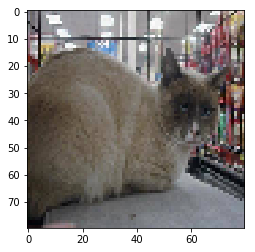

0.999999
dog


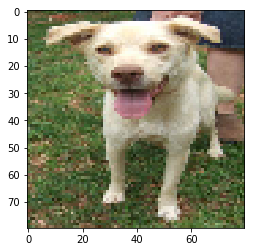

0.0782277
cat


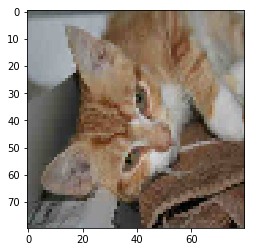

0.000705318
cat


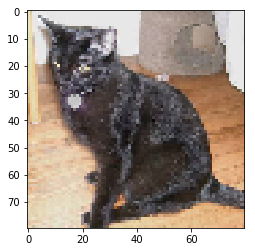

0.0869468
cat


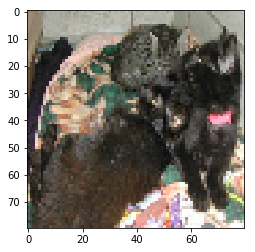

0.672097
dog


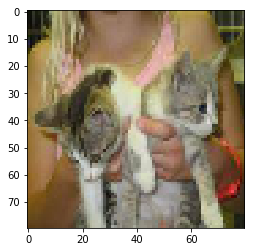

0.999964
dog


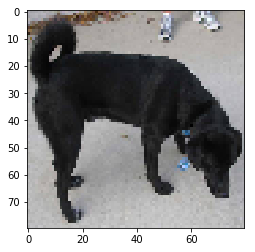

0.999516
dog


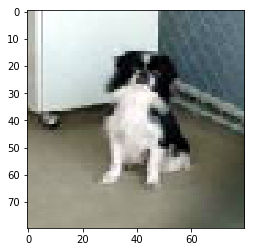

0.000110296
cat


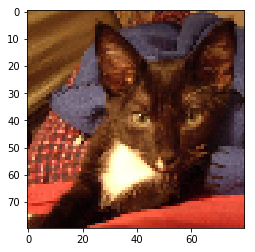

0.9999
dog


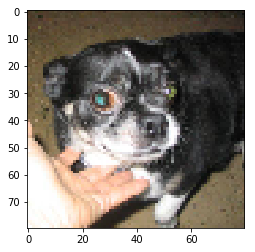

0.000576288
cat


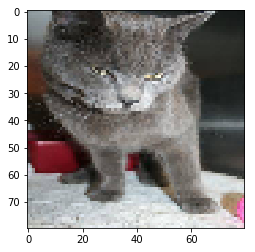

1.17835e-07
cat


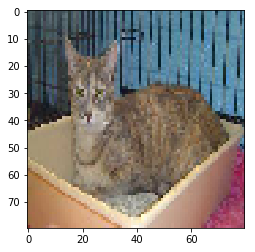

6.80438e-08
cat


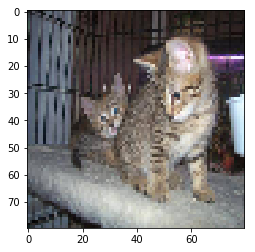

0.00244148
cat


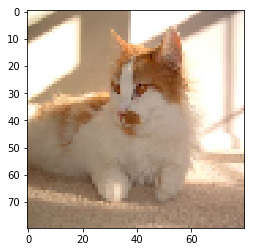

0.990081
dog


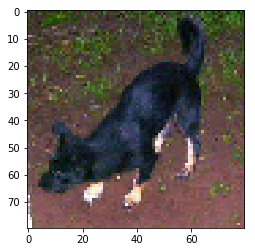

0.000214338
cat


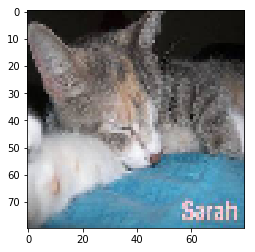

0.000426215
cat


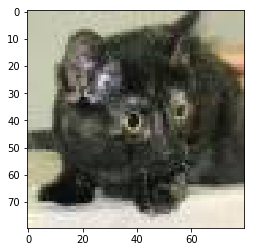

3.20361e-05
cat


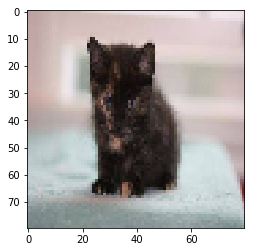

In [6]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

list_of_imgs = []
img_dir = "test1"
for img in os.listdir(img_dir):
    #load images
    img_name = os.path.join(img_dir, img)
    if not img.endswith(".jpg"):
        continue
    img = image.load_img(img_name, target_size=(80, 80))
    test_image = image.img_to_array(img) / 255
    
    #predict with test data
    x = model.predict(np.array([test_image]))
    if(x[0][0] < 0.5):
        print(x[0][0])
        print("cat")
    else:
        print(x[0][0])
        print("dog")
    plt.imshow(img)
    plt.show(img)